In [1]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys 
from scipy.stats import zscore

os.chdir('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning')
fold_path = 'allData/prognosis/pretreatment_response'
clinical_data = np.load(fold_path + '/baseline_clinical_data.npy', allow_pickle=True)
MMDT_score = np.load(fold_path + '/MMDT_score.npy', allow_pickle=True)
print(clinical_data)  



[[10 10 10 7 7 6 25]
 [nan 10 4 2 7 4 21]
 [7 8 9 3 2 6 27]
 [7 7 7 7 7 4 20]
 [4 8 4 1 0 4 17]
 [4 4 4 0 0 3 10]
 [7 6 7 0 5 3 15]
 [3 6 6 0 3 4 21]
 [nan 9 8 0 4 4 22]
 [8 8 8 3 7 4 21]
 [6 8 8 1 7 4 21]
 [4 7 6 0 3 4 21]
 [nan 7 5 0 0 4 19]
 [6 5 3 2 4 3 15]
 [9 9 9 2 2 4 23]
 [5 8 5 0 1 4 21]
 [7 6 5 0 4 4 19]
 [10 10 10 7 7 6 27]
 [6 4 4 0 2 3 15]
 [8 8 8 7 7 4 19]
 [8 6 5 5 7 3 15]
 [8 8 8 0 6 6 25]
 [10 9 7 5 5 4 22]
 [5 4 6 0 7 5 24]
 [7 9 9 3 3 7 30]
 [4 3 10 0 3 6 25]
 [6 9 8 7 7 6 26]
 [5 4 4 0 3 5 24]
 [7 6 2 7 7 6 26]
 [5 4 3 0 1 4 20]
 [5 8 7 3 4 4 23]
 [5 8 4 3 3 3 16]
 [4 6 5 2 2 4 20]
 [4 6 5 2 2 4 20]
 [8 6 10 0 3 5 24]
 [8 5 6 5 5 6 25]
 [5 3 6 6 6 4 22]
 [9 9 9 4 7 4 21]
 [6 7 2 0 2 3 16]
 [8 6 5 0 0 7 31]
 [7 7 6 3 7 6 26]
 [8 5 7 4 7 4 23]
 [nan 7 6 0 0 3 16]
 [6 7 6 5 5 3 12]
 [7 7 7 2 7 4 23]
 [7 9 3 3 7 4 21]
 [7 8 8 2 6 3 15]
 [4 2 2 0 2 3 14]
 [5 8 8 3 3 4 23]
 [9 10 7 3 7 6 26]
 [10 7 10 1 5 4 18]
 [10 6 5 1 2 4 19]
 [6 3 7 0 4 3 16]
 [7 7 0 0 0 3 10]
 [5 7 

In [2]:

def replace_nan_with_mean(data):
    input = data.copy()
    for i in range(input.shape[1]):
        col = input[:, i]
        col = np.array(col, dtype=float)
        mean_value = np.nanmean(col)
        col[np.isnan(col)] = mean_value
        input[:, i] = col
    return input
def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(clinical_data)
    return imputed_data

mean_data = replace_nan_with_mean(clinical_data)
imputed_data = impute_nan_data(clinical_data)

z_imputed_data = zscore(imputed_data, axis=0)

# add MMDT data


In [4]:
print(z_imputed_data.shape)
MMDT_score_1 = MMDT_score[:,1:]
print(MMDT_score_1.shape)

fusion_data = np.concatenate((z_imputed_data, MMDT_score_1), axis=1)
np.save(fold_path + '/fusion_data.npy', fusion_data)
# for i in range(fusion_data.shape[0]):
#     plt.plot(fusion_data[i,:], label='1')
#     plt.plot(fusion_data[i,:-2], label='2')
#     plt.legend()

(64, 7)
(64, 1)


In [83]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

X_train = fusion_data
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = CatBoostClassifier(verbose=0)

# 参数网格
param_grid = {
    'learning_rate': [1e-6],
    'depth': [4],
    'l2_leaf_reg': [5],
    'iterations': [100],
    'border_count': [32],


}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'border_count': 32, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 1e-06}
Best score: 0.7813852813852814


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

X_train = fusion_data
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = XGBClassifier(scale_pos_weight=61*1e5)

# 参数网格
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [4],  # Depth of trees. Increasing this value will make the model more complex and more likely to overfit.
    'learning_rate': [0.01],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'scale_pos_weight': [1e2],  # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 100.0}
Best score: 1.0


In [30]:
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = np.nan_to_num(demographic_data, 0)
demographic_data = zscore(demographic_data, axis=0)
print(demographic_data)

[[ 1.54893332  0.52915026 -0.60535015  2.1665957   0.81749636  6.79962494
  -1.51102763  1.03175391 -0.67419986 -0.5400228   1.13389342]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337  1.4832397   2.50951771  1.13389342]
 [-1.05259005 -1.88982237 -0.60535015 -0.42521972 -0.80064077 -0.40961596
   0.1855648  -0.96922337  1.4832397   3.52603121  1.13389342]
 [ 0.04278821  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648   1.03175391  1.4832397   1.4930042  -0.8819171 ]
 [ 1.82277789  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
  -1.51102763  1.03175391  1.4832397   0.4764907  -0.8819171 ]
 [ 0.72739963 -1.88982237 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [ 1.27508876  0.52915026  3.40248531 -0.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_validate

X_train = fusion_data[:, :2]# np.concatenate((fusion_data, demographic_data), axis=1)
models = {
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(scale_pos_weight=61 * 1e5),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'Support Vector': SVC(),
    'NearestNeighbor': KNeighborsClassifier(),
    'Perceptron': Perceptron()
}

results = {}

for model_name, model in models.items():
    # Define the scorers you want to use
    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score)}
    
    # Perform 5-fold cross-validation and get the results
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate mean scores
    mean_accuracy = cv_results['test_balanced_accuracy'].mean()
    mean_sensitivity = cv_results['test_sensitivity'].mean()
    
    # Store the results
    results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity}

results


{'CatBoost': {'bAcc': 0.5599999999999999, 'Sensitivity': 0.2},
 'XGBoost': {'bAcc': 0.48666666666666664, 'Sensitivity': 0.7333333333333333},
 'RandomForest': {'bAcc': 0.5633333333333332,
  'Sensitivity': 0.26666666666666666},
 'DecisionTree': {'bAcc': 0.5866666666666667,
  'Sensitivity': 0.3333333333333333},
 'Support Vector': {'bAcc': 0.5, 'Sensitivity': 0.0},
 'NearestNeighbor': {'bAcc': 0.5199999999999999, 'Sensitivity': 0.1},
 'Perceptron': {'bAcc': 0.5399999999999999, 'Sensitivity': 0.4}}

In [41]:
Y_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])

(array([41.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  3.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

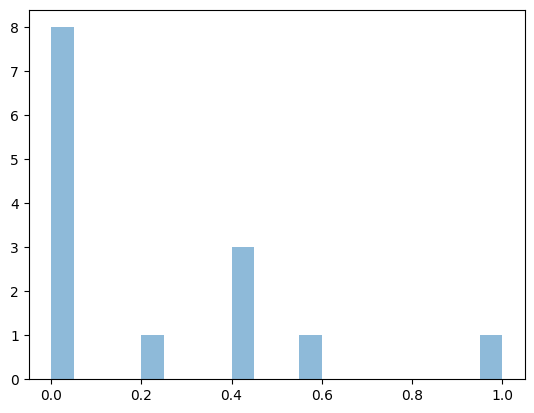

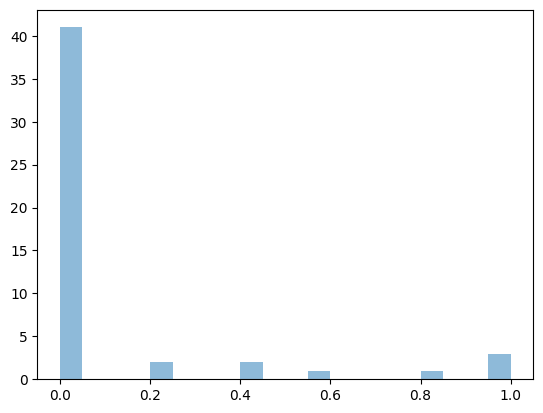

In [51]:
import matplotlib.pyplot as plt
fusion_data[:,-1:]

last_fusion_data = fusion_data[:,-1:].copy()
pos_las = last_fusion_data[Y_train == 1]
neg_las = last_fusion_data[Y_train == 0]
plt.hist(pos_las, bins=20, alpha=0.5, label='Positive')

plt.figure()
plt.hist(neg_las, bins=20, alpha=0.5, label='Negative')